## Import statements

In [2]:
from Scripte.korpus import Korpus
from Scripte.settings import Settings

import json
import re
import string
import spacy

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

from tqdm.notebook import tqdm
from functools import reduce
from pathlib import Path
from datetime import datetime
from collections import Counter

from spacy.lang.de import German

In [3]:
nlp = spacy.load("de_core_news_lg") # oder md  oder lg  wenn heruntergeladen

## Functions

In [4]:
def _convert_text(text:str) -> str:
    replacements = [(r"http.+?\s", " "), (r"([a-z])([A-Z])", r"\1 \2"), (r"", ""), 
                    (r"", ""), (r"\*{2,}", ""), ("_+", ""), ]
    for old, new in reversed(replacements):
        text = text.replace(old, new)
    return _convert_entities(text)

def _convert_entities(text:str) -> str:
    doc = nlp(text)
    for entity in reversed(doc.ents):
        text = text[:entity.start_char] + entity.label_ + text[entity.end_char:]
    return text
    

def _convert_wordcount(number: str) -> int:
    return int(number.replace(".", ""))

def _convert_release(date:str):
    return datetime.strptime(date.strip(), "%d.%m.%Y")
 
def old_create_df(path, gender):
    data = reduce(lambda a, b: a.append(b, ignore_index= True), tqdm([create_part(x) for x in path]))
    data["gender"] = gender
    return data

def create_df(path, gender, genre):
    data = pd.concat([create_part(x) for x in tqdm(path)], ignore_index=True)
    data["gender"] = gender
    data["genre"] = genre
    return data

def contains_words(string : str, words) -> bool:
    return any(x in string for x in words)

def create_part(file) -> pd.DataFrame:
    start = json.load(open(file))
    x = pd.DataFrame.from_dict(start["chapters"], orient= "index", columns=["text", "wordcount"])
    x["text"] = x["text"].apply(_convert_text)
    x["wordcount"] = x["wordcount"].apply(_convert_wordcount)
    x["novel"] = re.sub(r"\W", " ", start["title"])
    x["release"] = _convert_release(start["release"])
    return x 
    

### Korpus aufbauen

In [7]:
krimi_W = [x for x in Path("./jsondata/krimis/W").glob('**/*') if x.is_file() if x.suffix == ".json"]
krimi_M = [x for x in Path("./jsondata/krimis/M").glob('**/*') if x.is_file() if x.suffix == ".json"]
#horror
hor_W= [x for x in Path("./jsondata/horror/W").glob('**/*') if x.is_file() if x.suffix == ".json"]
hor_M= [x for x in Path("./jsondata/horror/M").glob('**/*') if x.is_file() if x.suffix == ".json"]
hor_unsp= [x for x in Path("./jsondata/horror/unspecified").glob('**/*') if x.is_file() if x.suffix == ".json"]
#abenteuer 
aben_W= [x for x in Path("./jsondata/abenteuer/W").glob('**/*') if x.is_file() if x.suffix == ".json"]
aben_M= [x for x in Path("./jsondata/abenteuer/M").glob('**/*') if x.is_file() if x.suffix == ".json"]
aben_unsp= [x for x in Path("./jsondata/abenteuer/unspecified").glob('**/*') if x.is_file() if x.suffix == ".json"]

#combined
json_M = krimi_M + hor_M + aben_M
json_W = krimi_W + hor_W + aben_W
json_unsp = hor_unsp + aben_unsp

### Diese Schritte brauchen eine Weile. Wenn ihr sie einmal durch habt, könnt ihr unten CSV save/ load verwenden 

In [6]:
data_krimi_M = create_df(krimi_M,"M", "krimi")


  0%|          | 0/31 [00:00<?, ?it/s]

In [7]:
data_krimi_W = create_df(krimi_W,"W","krimi")


  0%|          | 0/90 [00:00<?, ?it/s]

In [9]:
data_hor_M = create_df(hor_M, "M", "horror")
data_hor_W = create_df(hor_W,"W","horror")
data_hor_unsp = create_df(hor_unsp,"unsp", "horror")

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

In [9]:
data_aben_M = create_df(aben_M, "M", "abenteuer")
data_aben_W = create_df(aben_W,"W","abenteuer")
data_aben_unsp = create_df(aben_unsp,"unsp", "abenteuer")

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

In [11]:
#data_krimi_full = pd.concat([data_krimi_M, data_krimi_W],ignore_index=True)
#data_aben_full = pd.concat([data_aben_M, data_aben_W, data_aben_unsp],ignore_index=True)
data_hor_full = pd.concat([data_hor_M, data_hor_W, data_hor_unsp],ignore_index=True)

## Summen der Wörter

## load and save from csv


In [13]:
#data_krimi_full.to_csv("csv_data_krimi_full.csv", sep ="|")
#data_aben_full.to_csv("csv_data_aben_full.csv", sep="|")
#data_hor_full.to_csv("csv_data_hor_full.csv",sep="|")

In [5]:
data_krimi_full= pd.read_csv("csv_data_krimi_full.csv", sep ="|")
data_aben_full= pd.read_csv("csv_data_aben_full.csv", sep="|")
data_hor_full = pd.read_csv("csv_data_hor_full.csv",sep="|")

## build from csv files all permutations

In [6]:
data_krimi_M = data_krimi_full.loc[data_krimi_full["gender"] == "M"]
data_krimi_W = data_krimi_full.loc[data_krimi_full["gender"] == "W"]
data_aben_M = data_aben_full.loc[data_aben_full["gender"] == "M"]
data_aben_W = data_aben_full.loc[data_aben_full["gender"] == "W"]
data_aben_unsp = data_aben_full.loc[data_aben_full["gender"] == "unsp"]
data_hor_M = data_hor_full.loc[data_hor_full["gender"] == "M"]
data_hor_W = data_hor_full.loc[data_hor_full["gender"] == "W"]
data_hor_unsp = data_hor_full.loc[data_hor_full["gender"] == "unsp"]

# full gender views

data_all_M = pd.concat([data_krimi_M, data_aben_M, data_hor_M], ignore_index=True)
data_all_W = pd.concat([data_krimi_W, data_hor_W, data_aben_W], ignore_index=True)
data_all_unsp = pd.concat([data_aben_unsp, data_hor_unsp], ignore_index=True)

data_all = pd.concat([data_krimi_full, data_aben_full, data_hor_full], ignore_index=True)

# Analyse und Berechnung

## Vorbereitung

In [7]:
joined_text_krimi_M = data_krimi_M.groupby('novel')['text'].apply(' '.join)
joined_text_krimi_W = data_krimi_W.groupby('novel')['text'].apply(' '.join)
joined_text_krimi_full = pd.concat([joined_text_krimi_M,joined_text_krimi_W])

In [8]:
joined_text_aben_W = data_aben_W.groupby('novel')['text'].apply(' '.join)
joined_text_aben_M = data_aben_M.groupby('novel')['text'].apply(' '.join)
joined_text_aben_unsp = data_aben_unsp.groupby('novel')['text'].apply(' '.join)
joined_text_aben_full = pd.concat([joined_text_aben_M, joined_text_aben_W, joined_text_aben_unsp])

joined_text_hor_W = data_hor_W.groupby('novel')['text'].apply(' '.join)
joined_text_hor_M = data_hor_M.groupby('novel')['text'].apply(' '.join)
joined_text_hor_unsp = data_hor_unsp.groupby('novel')['text'].apply(' '.join)
joined_text_hor_full = data_hor_full.groupby('novel')["text"].apply(' '.join)

joined_text_M_full = pd.concat([joined_text_krimi_M,  joined_text_aben_M]) #joined_text_hor_M,
joined_text_W_full = pd.concat([joined_text_krimi_W,  joined_text_aben_W])#joined_text_hor_W,
joined_text_unsp_full = pd.concat([joined_text_aben_unsp, joined_text_hor_unsp])

In [9]:
joined_text_all = data_all.groupby('novel')['text'].apply(' '.join)


## Dieser Schritt braucht etwas!

In [11]:
brut_list = 'brutal schlagen schlug mord misshandeln vergewaltigen überfall tod töten tot treten tritt trat verfolgen hart extrem attacke angriff angreifen metzeln reißen missbrauch zerstören prügel rücksichtslos qual quälen blut griff gewalt tat härte diktator krieg schlacht anschlag schläge terror folter killer teulisch gemein brechen bombe sadistisch erbarmungslos barbarisch knochen verletzen roh grob kampf waffen messer knüppel stoßen lust sexuell diebstahl vandalismus amok belästigen mobbing brand demütigen erpressen nötigung rassismus sabotage stalker hass psychisch einschüchtern entführung beleidigen schimpfen schrei ohrenbetäubend betäubung drogen spritzen kämpfen boxen knöchel schlitzen brechen gedärme teufel dämon bestie schreck hexe kriminalität kriminell liste böse prositution schänden schand entblößen entstellen pervers mafia bosheit fleischwunde gebeine skelett gerippe meucheln umbringen auslöschen kannibale sterben pistole gewehr klinge cutter verbrecher dieb straftäter assassine vergehen entehren unterwerfen entmenscht genitalien faust attentat säge'

brut_final = [token.lemma_ for token in nlp(brut_list)]

def get_brut_ratio(series)-> pd.DataFrame:
    results = []
    for novel, text in series.items():
        if len(text)> nlp.max_length:
            for x in _get_results(novel,text):
                results.append(x)
                print(f"LOG: finished {novel}")
        else:
            results.append([novel]+calc_data(text))
            print(f"LOG: finished {novel}")
        #results.append([novel, brut_sum, brut_types, total_words, percentage])   
    df = pd.DataFrame(results, columns=['novel', 'brut_sum', 'brut_type', 'Total Words', 'Percentage'])

    return df

def _get_results(novel:str, text:str):
    results = []
    chunks = [text[i:i+nlp.max_length] for i in range(0, len(text), nlp.max_length)]
    for i, chunk in enumerate(chunks):
        str_ = f"{novel}_{i}"
        results.append([str_]+ calc_data(chunk))
    return results

def calc_data(text): 
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.lemma_ != "--"]
    count_part = Counter([lemma for lemma in lemmas if lemma in brut_final])
    brut_sum = sum(count_part.values())
    brut_types = len(count_part)
    total_words = len(lemmas)
    percentage = (brut_sum / total_words) * 100
                       
    return [brut_sum, brut_types, total_words, percentage]


# Dies hier wird weiter bearbeitet!

In [120]:
# Set max_length according to your PC, the higher, the more RAM is required 100000 ~~ 1 GB
nlp.max_length = 600000

# Choose those you want to view/compare/plot later, results in DFs
data_comp1 = get_brut_ratio(joined_text_krimi_W)
data_comp1["field"] = "krimi_W"
data_comp2 = get_brut_ratio(joined_text_krimi_M)
data_comp2["field"] = "krimi_M"


LOG: finished Albtraum
LOG: finished Alina
LOG: finished Aller Anfang ist schwer
LOG: finished Angel  Arbeitstitel 
LOG: finished Anonym
LOG: finished Auf den Spuren der Vergangenheit
LOG: finished Authorities Task Force
LOG: finished Being Jack
LOG: finished Broken Mirrors   
LOG: finished Bruderliebe
LOG: finished CRY
LOG: finished Cube
LOG: finished Das Attentat
LOG: finished Das Böse hat ein Herz
LOG: finished Das mörderische Krimidinner
LOG: finished Death Teacher
LOG: finished Der Anfang der Katastrophen oder London calling
LOG: finished Der Diamantenprinz
LOG: finished Der Fall Lukis
LOG: finished Der Herzensbrecher
LOG: finished Der Mountie   Das Geheimnis der toten Elche
LOG: finished Der Zweck heiligt die Mittel
LOG: finished Der erste Fall
LOG: finished Die Entführung
LOG: finished Die Fassade
LOG: finished Die Nacht im Mai
LOG: finished Die Stunde der Angst
LOG: finished Die weiße Witwe
LOG: finished Eiskalt
LOG: finished Emma
LOG: finished Falsche Sterne über Tokyo
LOG: fi

In [104]:
data_comp3 = get_brut_ratio(joined_text_aben_unsp)
data_comp3["field"] = "aben_unsp"

LOG: finished  EXIT 
LOG: finished  Game Over 
LOG: finished  Leseprobe   Die Zeitagentin
LOG: finished  Leseprobe   Sehnsucht nach Freiheit
LOG: finished  Trigger and Suggestion 
LOG: finished Alles und Nichts
LOG: finished Chroniken der Stämme Spotlight  Licht und Schatten  Teil 2 
LOG: finished Das Leben ist kein Ponyhof   Das Geheimnis von Whitehorse Castle  MMFF Anmeldung geschlossen 
LOG: finished Das Leben ist kein Ponyhof   Das Geheimnis von Whitehorse Castle  MMFF Anmeldung geschlossen 
LOG: finished Der Weg des Herzens
LOG: finished Die Arena der Adler
LOG: finished Die Fahrt auf der Fetten Witwe   Testament eines Meisterdiebes
LOG: finished Die Lagune unter der Treppe
LOG: finished Die Wolfsprinzessin
LOG: finished Ein Held oder Monster 
LOG: finished Entscheide dich  Krieg oder Liebe 2    Drittes Reich x Sowjet Union   Countryhumans
LOG: finished Erwachen   Die Welt nach dem Ende
LOG: finished Freunde durch dick und dünn
LOG: finished Glück auf beim Erkunden
LOG: finished G

In [121]:
data_final = pd.concat([data_comp1, data_comp2,
                        #data_comp3
                       ])

In [122]:
data_final.to_csv("csv_analyse_data_krimi.csv", sep ="|")

In [132]:
data_final = pd.read_csv("csv_analyse_data_hor.csv", sep ="|" )

In [133]:
data_final

,Unnamed: 0,novel,brut_sum,brut_type,Total Words,Percentage,field
0,0,43 Stunden,81,25,13566,0.597081,hor_W
1,1,7 Tage Wahnsinn,136,31,12090,1.124897,hor_W
2,2,Aloha From Hell,150,33,19602,0.765228,hor_W
3,3,Am Ende des Tages,148,29,13800,1.072464,hor_W
4,4,Amusement Park,122,24,18122,0.673215,hor_W
...,...,...,...,...,...,...,...
161,48,The cursed castle,120,25,14331,0.837346,hor_unsp
162,49,Von Gänsehaut und Geistern,99,26,15760,0.628173,hor_unsp
163,50,Was ist aus mir geworden,93,31,10643,0.873814,hor_unsp
164,51,Winternacht,128,23,23879,0.536036,hor_unsp


## Plotting


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

In [145]:
# to make sure to not lose data, plots can be saved, make sure you change filename if you use this option
SAVE_FILES = True

subdirectory = Path('plots')
subdirectory.mkdir(parents=True, exist_ok=True)
#FILENAME- CHANGE THIS
plot_name = 'bar_hor_full_brut_type.png'
file_path = subdirectory / plot_name

In [144]:
df =  data_final.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

# Viewing the Data

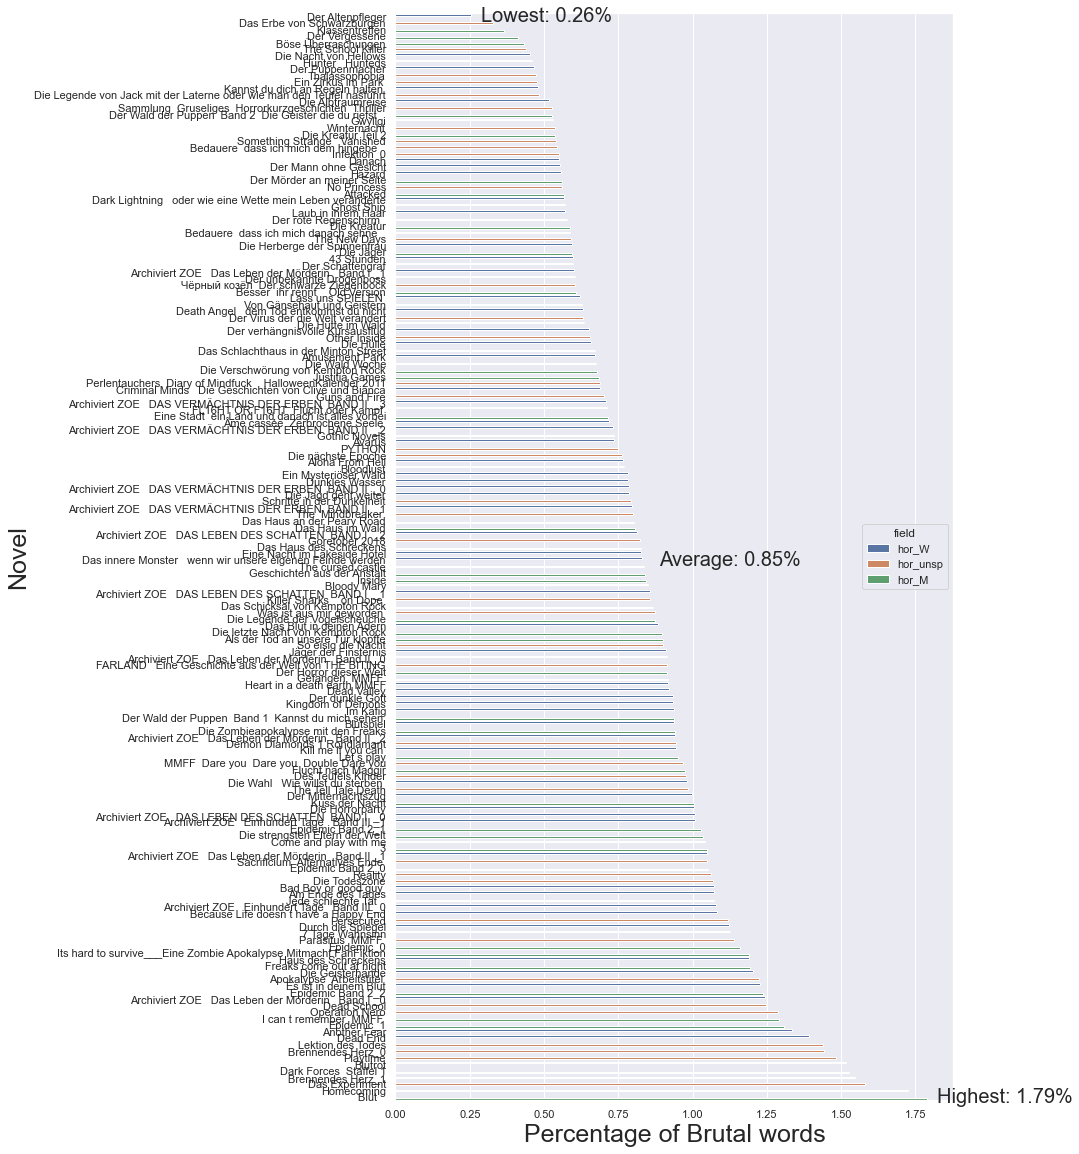

In [98]:
sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', hue='field', data=df)

plt.xlabel('Percentage of Brutal words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df['Percentage'].max()
lowest_percentage = df['Percentage'].min()
average_percentage = df['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

# Comparison plots

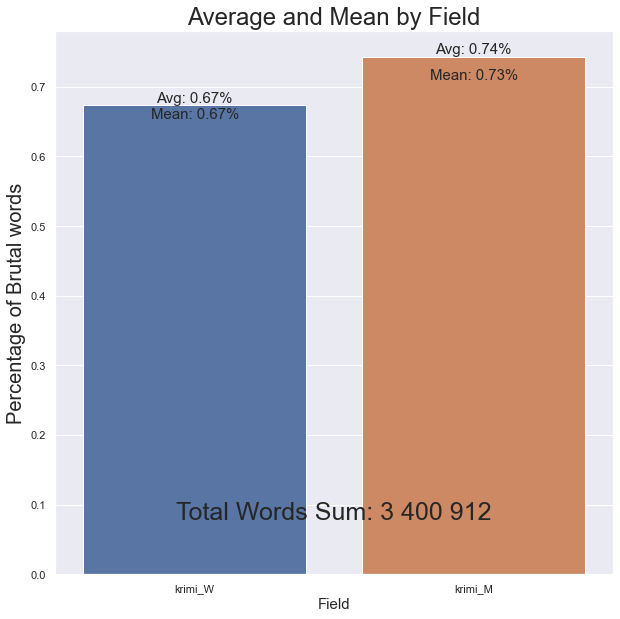

In [128]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.barplot(data=df, x='field', y='Percentage', ci= None)

# Calculate and display average and mean for each group
average_per_group = df.groupby('field')['Percentage'].mean()
mean_per_group = df.groupby('field')['Percentage'].median()
total_words_sum = df['Total Words'].sum()

for i, field in enumerate(df['field'].unique()):
    plt.text(i, average_per_group[field], f'Avg: {average_per_group[field]:.2f}%', ha='center', va='bottom', fontsize=15)
    plt.text(i, mean_per_group[field], f'Mean: {mean_per_group[field]:.2f}%', ha='center', va='top', fontsize=15)

plt.xlabel('Field', fontsize=15)
plt.ylabel('Percentage of Brutal words', fontsize=20)
plt.title('Average and Mean by Field', fontsize=24)

plt.text(0.5, 0.1, f"Total Words Sum: {'{:,.0f}'.format(total_words_sum).replace(',', ' ')}",
         ha= "center", transform=plt.gca().transAxes, fontsize=25)
    

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

# Brut Types

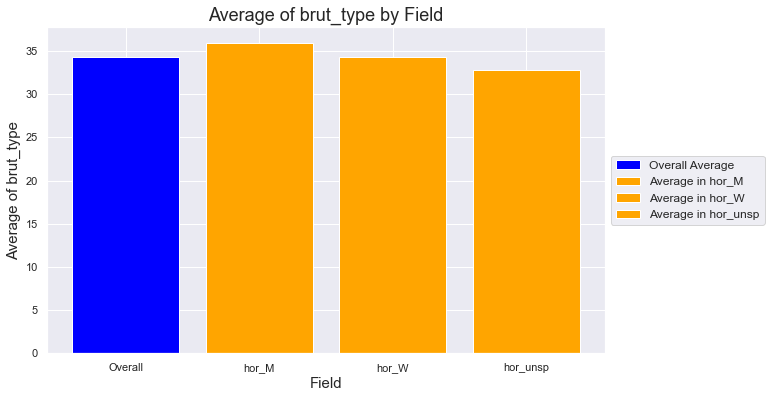

In [146]:
overall_avg_brut_type = df['brut_type'].mean()

# Calculate the average of "brut_type" for each unique group in the 'field' column
avg_brut_type_by_field = df.groupby('field')['brut_type'].mean()

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a barplot to display the overall average and averages by field
plt.bar("Overall", overall_avg_brut_type, label='Overall Average', color='blue')
for field, avg in avg_brut_type_by_field.items():
    plt.bar(field, avg, label=f'Average in {field}', color='orange')

plt.xlabel('Field', fontsize=15)
plt.ylabel('Average of brut_type', fontsize=15)
plt.title('Average of brut_type by Field', fontsize=18)
plt.legend(fontsize=12)

plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

# Specify the file path relative to the subdirectory and format (e.g., PNG)
plt.savefig(file_path, dpi=300, bbox_inches='tight')

# To save in other formats, change the file extension (e.g., 'average_brut_type.jpg', 'average_brut_type.pdf')

plt.show()

In [147]:
from scipy import stats
df = data_final

male_data = df[df['field'] == 'hor_M']['Percentage']
female_data = df[df['field'] == 'hor_W']['Percentage']
print(len(male_data))
print(len(female_data))

# Durchführung des T-Tests
t_statistic, p_value = stats.ttest_ind(male_data, female_data, equal_var=True)

# Ausgabe der Testergebnisse
print(f'T-Statistik: {t_statistic}')
print(f'p-Wert: {p_value}')

# Interpretation der Ergebnisse
alpha = 0.05  # Signifikanzniveau
if p_value < alpha:
    print("Der Unterschied im Anteil der brutalen Worte zwischen männlichen und weiblichen Autoren ist statistisch signifikant.")
else:
    print("Es gibt keinen statistisch signifikanten Unterschied im Anteil der brutalen Worte zwischen männlichen und weiblichen Autoren.")


41
72
T-Statistik: 1.2518774546793983
p-Wert: 0.21324610124964624
Es gibt keinen statistisch signifikanten Unterschied im Anteil der brutalen Worte zwischen männlichen und weiblichen Autoren.
